In [1]:
import os
import pickle
import random
import logging
import argparse

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from timeit import default_timer as timer
from datetime import timedelta

from models import WordEncoder, Attention, TagEmbedding, WordDecoder, MSVED, KumaMSD
from dataset import MorphologyDatasetTask3, Vocabulary

from kumaraswamy import Kumaraswamy
from hard_kumaraswamy import StretchedAndRectifiedDistribution as HardKumaraswamy

from main import *

In [6]:
def plot_function(sample, actual, vocab):
    x_labels = list(vocab.idx_2_desc.values())

    fig, ax = plt.subplots()
    im = ax.imshow(torch.cat((sample, actual), 0).cpu())

    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_yticks(np.arange(2))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(['sample', 'actual'])

    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")
    plt.show()


In [10]:
def test_kuma(model, kumaMSD, test_loader):
    '''
    Test function
    '''
    model.eval()
    kumaMSD.eval()
    for i_batch, sample_batched in enumerate(test_loader):

        with torch.no_grad():
            x_s = sample_batched['source_form'].to(device)
            x_t = sample_batched['target_form'].to(device)
            y_t = sample_batched['msd'].to(device)

            x_s = torch.transpose(x_s, 0, 1)
            x_t = torch.transpose(x_t, 0, 1)
            y_t = torch.transpose(y_t, 0, 1)

            x_t_p, _, _ = model(x_s, x_t, y_t)
            sample, _   = kumaMSD(x_t)
            actual      = torch.sum(y_t, 0)
            
            x_t_p       = x_t_p[1:].view(-1, x_t_p.shape[-1])

            outputs     = F.log_softmax(x_t_p, dim=1).type(torch.LongTensor)
            outputs     = torch.squeeze(outputs, 1)

            target_word = ''
            for i in outputs:
                p       = np.argmax(i, axis=0).detach().cpu().item()
                entity  = idx_2_char[p]

                if   entity == '<SOS>':
                    continue
                elif entity == '<PAD>' or entity == '<EOS>':
                    break

                target_word += idx_2_char[p]
            
        return target_word, sample_batched, sample, actual, vocab

In [12]:
language = 'turkish'
model_id = '17'

device         = torch.device('cuda')
checkpoint     = torch.load('../models/{}-{}/model.pt'.format(language, model_id), map_location=device)

config         = checkpoint['config']
vocab          = checkpoint['vocab']

test_loader, d = initialize_dataloader(run_type='test', language=config['language'], task='sup',
                                       vocab=vocab, batch_size=1, shuffle=True)
idx_2_char     = d.idx_2_char

model, kumaMSD = initialize_model(config)
model.load_state_dict(checkpoint['model_state_dict'])
kumaMSD.load_state_dict(checkpoint['kumaMSD_state_dict'])

hello


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

Source          : ['kıblesi']
MSD             : ['pos=N,poss=PSS1S,case=ACC,num=SG']
Target          : ['kıblemi']
Predicted target: ['kıblemi']


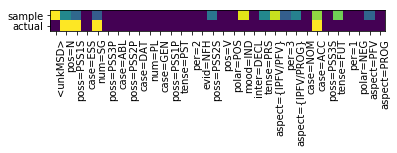

In [23]:
target_word, info, sample, actual, vocab = test_kuma(model, kumaMSD, test_loader)

print('Source          : {}'.format(info['source_str']))
print('MSD             : {}'.format(info['msd_str']))
print('Target          : {}'.format(info['target_str']))
print("Predicted target: ['{}']".format(target_word))

plot_function(sample, actual, vocab)

In [36]:
print(kumaMSD)

print(kumaMSD.ai.weight.size())

KumaMSD(
  (encoder): WordEncoder(
    (embedding): Embedding(39, 300, padding_idx=2)
    (rnn): GRU(300, 256, bidirectional=True)
    (fc_mu): Linear(in_features=512, out_features=150, bias=True)
    (fc_sigma): Linear(in_features=512, out_features=150, bias=True)
    (dropout): Dropout(p=0.0)
  )
  (fc): Linear(in_features=512, out_features=256, bias=True)
  (ai): Linear(in_features=256, out_features=32, bias=True)
  (bi): Linear(in_features=256, out_features=32, bias=True)
)
torch.Size([32, 256])


In [38]:
print(kumaMSD.ai.weight[0])
print(kumaMSD.bi.weight)

# for param in kumaMSD.parameters():
#     print(param.size())

tensor([-0.0563,  0.0150,  0.0066, -0.0435, -0.0751, -0.0397,  0.0530,  0.0209,
         0.0152,  0.0619,  0.0186, -0.0383,  0.0393, -0.0211,  0.0879,  0.0261,
         0.0294,  0.0384,  0.0128, -0.0092,  0.0559,  0.0228, -0.0505, -0.0353,
        -0.0351,  0.0237, -0.0197,  0.0239,  0.0557,  0.0377, -0.0372, -0.0057,
        -0.0267,  0.0611,  0.0055,  0.0301, -0.0628,  0.0085,  0.0703,  0.0382,
         0.0026, -0.0025, -0.0387, -0.0266,  0.0458, -0.0020,  0.0566,  0.0290,
         0.0541,  0.0596, -0.0164,  0.0447,  0.0120,  0.0170,  0.0130,  0.0716,
         0.0092,  0.0548, -0.0230,  0.0232,  0.0011, -0.0997,  0.0789, -0.0230,
        -0.0490, -0.0154, -0.0058,  0.0313,  0.0586,  0.0611, -0.0186, -0.0236,
        -0.0626,  0.0135, -0.0385, -0.0970, -0.0534, -0.0179, -0.0210, -0.0240,
         0.0317,  0.0515, -0.0309,  0.0298, -0.0008,  0.0034,  0.0845,  0.0720,
         0.0155,  0.0348,  0.0354,  0.0498,  0.0761,  0.0165,  0.0369, -0.0537,
        -0.0066,  0.0122,  0.0216,  0.00